# Keras で MNIST データの学習を試してみよう

人工知能・機械学習を学習する際に、チュートリアルとして頻繁に利用されるデータに **MNIST** のデータがあります。 手書きの数字を白黒画像にしたデータで、「手書きの数字を認識できる人工知能を作る」というチュートリアルに良く利用されます。 ここでは人工知能ライブラリ **Keras** で MNIST データを学習させ、手書き数字を認識できる人工知能を作ります。

## どのような人工知能を作るのか？
まずは、どのような人工知能を作ろうとしているのかを整理してみましょう。

### 実現したいこと (作成する人工知能の能力)
今回利用する MNIST のデータは、(1)次のような手書きの 0 〜 9 の数字が書かれた画像データ と、(2)その画像に書かれた実際の数字データ のペアです。

<img src="https://weblabo.oscasierra.net/wp-content/uploads/2017/08/python-ai-mnist-data-detail-1.png" alt="MNISTデータ" style="max-width:80%;">

ここで作成する人工知能とは、1つの数字が書かれた1つの画像データを人工知能に入力した際に、その画像になんの数字が書かれているのかを分類できる人工知能です。

### 入力データ
前述の通り、入力データは1つの数字が書かれた画像データです。 MNISTの画像1つは 28×28 ピクセル(＝784ピクセル)の大きさです。 1ピクセルごとに「白」〜「黒」までの色情報が記録されています。 1つの画像の全てのピクセルの情報を人工知能の入力としますので、入力の数は784個になります。

### 出力データ
画像データを入力された人工知能は、どの数字の画像なのかを考えたあとに、「0」〜「9」までの数字毎にその確率を出力します。 例えば次の表のようなイメージです。 次の表の例だと「3」の確率が一番高いので、人工知能が「3」だと判断したことになります。 このように数字ごとに確率を出力するので、出力の数は10個になります。

| 数字 | 確率  |
|:----|:------|
| 0   | 0.014 |
| 1   | 0.001 |
| 2   | 0.013 |
| 3   | 9.134 |
| 4   | 0.316 |
| 5   | 0.043 |
| 6   | 0.136 |
| 7   | 0.165 |
| 8   | 0.129 |
| 9   | 0.049 |



## 利用するライブラリのインポート
まずは、今回のプログラムで利用するライブラリを読み込みます。 すべて Keras のライブラリです。

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt

Using TensorFlow backend.


## MNISTデータの準備
人工知能に学習させる MNIST データを準備します。 MNIST データは、学習用のデータを 60,000 個、検証用のデータを 10,000 個提供してくれています。

### MNISTデータの読込み
まずは MNIST データをプログラムから読込みます。 Keras がチュートリアル用に読込み関数を用意してくれているので、 mnist.load_data() 関数を呼び出すだけです。 この関数はコンピュータ内に MNIST データがない場合はインターネットからダウンロードすることもやってくれるので、あらかじめ手元に MNIST データを用意するようなことは必要ありません。
MNIST データを読み込んだあとに、データが格納されたそれぞれの配列の形(shape)を出力してみると次のようになります。

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("x_train.shape(学習用の画像データ) : ", x_train.shape)
print("y_train_shape(学習用の正解データ) : ", y_train.shape)
print("x_test.shape(検証用の画像データ) : ", x_test.shape)
print("y_test.shape(検証用の正解データ) : ", y_test.shape)

x_train.shape(学習用の画像データ) :  (60000, 28, 28)
y_train_shape(学習用の正解データ) :  (60000,)
x_test.shape(検証用の画像データ) :  (10000, 28, 28)
y_test.shape(検証用の正解データ) :  (10000,)


### 入力データの加工
この時点では 60,000 個の画像が、それぞれ 28×28 の二次元で表現されています。 前述の通り、入力となる画像の情報は784個になるようにしたいので、1次元になるように変形させます。

In [3]:
x_train  = x_train.reshape(60000, 784)
x_test   = x_test.reshape(10000, 784)
print("x_train.shape(学習用の画像データ) : ", x_train.shape)
print("y_train_shape(学習用の正解データ) : ", y_train.shape)
print("x_test.shape(検証用の画像データ) : ", x_test.shape)
print("y_test.shape(検証用の正解データ) : ", y_test.shape)

x_train.shape(学習用の画像データ) :  (60000, 784)
y_train_shape(学習用の正解データ) :  (60000,)
x_test.shape(検証用の画像データ) :  (10000, 784)
y_test.shape(検証用の正解データ) :  (10000,)


また、MNIST のピクセルの情報は、0〜255 の数値で提供されており、0 が白、255に近くにつれて黒になるような数字になっています。 数値計算の都合上、入力を 0〜1の範囲の数値にした方が良いため、データ型を float に変換したのち、255 で割ります。

In [4]:
# データを float 型に変換
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# 0〜255 までの範囲のデータを 0〜1 までの範囲に変更
x_train /= 255
x_test  /= 255

### 正解データの加工
次に正解データを加工します。 MNIST の正解データは、対となる画像に何の数字が書かれているかを表す「0」〜「9」の数字を提供してくれています。 しかし、ここで作成する人工知能は前述の通り出力が10個の確率になりますので、今のままでは比較が難しいです。 そこで「0」〜「9」までの数字の形を変換します。 どのように変換するのかといえば、例えば「4」という数字であれば [0,0,0,0,1,0,0,0,0,0] というような、「4」を表す値だけが「1」となるような1次元配列にするのです。

In [5]:
y_train = keras.utils.to_categorical(y_train, 10)
y_test  = keras.utils.to_categorical(y_test, 10)

### データ加工後の最終状態
ここまでで、MNIST のデータを今回作成する人工知能が学習をしやすい形に変換してきました。 最終的には次のようになりました。

- 学習用の画像データ : 画像1つ分の情報を人工知能に与えられるように、長さが784の1次元配列に整形した。 それが 60,000個の画像分ある。
- 学習用の正解データ : 人工知能の出力は「0」〜「9」の数字毎に確率が算出されるため、それに合わせて「0」〜「9」の数字を長さ10の一次元配列に整形した。 それが画像データと対になるように 60,000個ある。
- 検証用の画像データ : 学習用の画像データと同じように整形。 10,000個の画像分のデータがある。
- 検証用の正解データ : 学習用の正解データと同じように整形。 検証用の画像データと対になるように 10,000個ある。

In [6]:
print("x_train.shape(学習用の画像データ) : ", x_train.shape)
print("y_train_shape(学習用の正解データ) : ", y_train.shape)
print("x_test.shape(検証用の画像データ) : ", x_test.shape)
print("y_test.shape(検証用の正解データ) : ", y_test.shape)

x_train.shape(学習用の画像データ) :  (60000, 784)
y_train_shape(学習用の正解データ) :  (60000, 10)
x_test.shape(検証用の画像データ) :  (10000, 784)
y_test.shape(検証用の正解データ) :  (10000, 10)


## モデルの構築
さて、ここからがやっと人工知能をつくるパートです。 まずは人工知能のモデルを作成します。 作りたいモデルの仕様は次のようなものです。

  1. 入力の数は784個である。 これは画像1つが784ピクセルの大きさであるため。
  2. 出力の数は10個である。 与えた画像が、数字「0」〜「9」のどれにあたるかを、それぞれの数字毎に確率を算出させるため。

ここでは、次のようにモデルを構築します。

In [7]:
# Dense : 第1引数で出力の次元数を指定します。入力の次元数はinput_shapeで指定します(指定しない場合は出力と同じ)
model = Sequential()
model.add(InputLayer(input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

# モデルをコンパイルする
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## 学習

　モデルを作り終えたら、ついに本題の「学習」になります。 学習のフェーズで重要なのは、**学習回数**です。 簡単に例えるなら「1冊の学習ドリルを何回学習したか」みたいな感じです。 人工知能も同じ問題を何度も反復することで賢くなります。 学習用データを何度もモデルに入力することが大切です。

In [8]:
epochs = 20
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s - loss: 0.6019 - acc: 0.8504 - val_loss: 0.3405 - val_acc: 0.9076
Epoch 2/20
60000/60000 [==============================] - 1s - loss: 0.3308 - acc: 0.9079 - val_loss: 0.3008 - val_acc: 0.9169
Epoch 3/20
60000/60000 [==============================] - 1s - loss: 0.3019 - acc: 0.9163 - val_loss: 0.2859 - val_acc: 0.9191
Epoch 4/20
60000/60000 [==============================] - 1s - loss: 0.2888 - acc: 0.9198 - val_loss: 0.2789 - val_acc: 0.9212
Epoch 5/20
60000/60000 [==============================] - 1s - loss: 0.2802 - acc: 0.9220 - val_loss: 0.2751 - val_acc: 0.9234
Epoch 6/20
60000/60000 [==============================] - 1s - loss: 0.2747 - acc: 0.9235 - val_loss: 0.2731 - val_acc: 0.9244
Epoch 7/20
60000/60000 [==============================] - 1s - loss: 0.2708 - acc: 0.9250 - val_loss: 0.2712 - val_acc: 0.9256
Epoch 8/20
60000/60000 [==============================] - 1s 

## 評価
　それでは最後に、出来上がった人工知能モデルが、どれだけ優秀なのかを評価しましょう。 出来上がった人工知能モデルに検証用データ (x_test と y_test )を与えて、正解率を求めて評価します。

In [9]:
score = model.evaluate(x_test, y_test, verbose=1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 8768/10000 [=========================>....] - ETA: 0s ETA: 
Test loss: 0.270944403698
Test accuracy: 0.9276


accuracy とは日本語で「正確さ」という意味で、今回の場合であれば「画像を認識できる確率」を表しています。

## 学習経過の可視化
　ここまでで、人工知能のモデルの作成と評価は完了です。 結果として、0.92 と言うスコアを持つ賢さの人工知能を作り出すことができました。 さて、気になるのは「成果のある学習が行えたのか？ 学習して賢くなったのか？」ということではないでしょうか。 学習を繰り返すたびに賢くなっていることが、視覚的にわかるととても安心できます。

　上で実行した model.fit() の戻り値 history から、学習経過を可視化することができます。 history には学習状況が格納されており、次のようなものを含んでいます。

　**loss** : loss は日本語で**損失**と訳されます。 ここでの loss は、学習用データで学習を終えた際の「損失」の値です。 値の意味としては、小さい数字ほど正しい結果を出せるように学習できたことを表し、逆に値が大きい場合は正しい結果を出せていないことを表します。
 
　** val_loss** : val_loss は、検証用データを与えて試した際に、どれだけ正しい結果を出せたのかということを表します。 値が小さいほど正しい結果を出せ、値が大きいほど正しい結果をだせていないことを表します。

　総じて、loss は学習状況を示す指標となる数字だと覚えておけばよいでしょう。

| 項目 | 概要 |
|:----|:----|
| loss | 学習用データを与えた際の損失値。 簡単にいうと、この値が小さければ小さいほど賢くなったことを表し、逆に値が大きければ学習が不十分だということを表します。 |
| val_loss | 検証データを与えた際の損失値。 意味は loss 同様。 |

　この loss と val_loss の値を二次元グラフにして表示してみます。 縦軸には loss の値を、横軸には学習回数(ここでは20回学習させている)を割り当てて、学習ごとの loss と val_loss をグラフにしてみます。

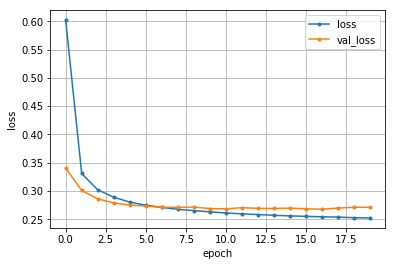

In [10]:
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

　生成されたグラフからは、次のようなことがわかります。

  - loss が徐々に下がっており、学習用データによる学習は順調に行われたようにみえる。
  - 実際の検証においては、最初の数回の検証においては val_loss が徐々にさがっており、学習が効果があったことがわかる。しかし、5回目くらい以降の検証では val_loss が横ばいとなっている。

　このことから、じつは5回目くらい以上の学習は、あまり効果がなかったかもしれません。 学校のテストに例えると「試験勉強はたくさんやって知識が増えたが、実際の試験では勉強した分だけの点数を取れなかった」ということかもしれません。 もし、もっと高いスコアを目指したいのであれば、今回の学習方法よりも良い学習方法を取り入れないといけないのかもしれません。 本稿で作成したモデルは、とても初歩的でシンプルなモデルでした。 人工知能に関する学習をすすめ、もっと良いモデルを作れれば、もっと賢い・ハイスコアを出せるかもしれません。

## まとめ
　今回は、人工知能ライブラリ **Keras** を利用した MNIST データの学習について解説しました。 ここで解説したモデルは、とても初歩的でシンプルなモデルです。 ぜひ様々なモデルの作り方を知って、人工知能の知識を深めていってください。